In [1]:
import numpy as np
from matplotlib import pyplot as plt


In [2]:
#num_buttons = 4

# all resistor values in kilo Ohm
ra_list = [1,1,1,1,.680]
rb = 100

num_buttons = len(ra_list)-1

num_ladder_r = num_buttons +1

In [3]:
# generate a list of all combinations of one or two button presses

combinations = []

for i in range(0,2**num_buttons):
  myvec = [0]*num_buttons
  for j in range(0,num_buttons):
    k = (i & 1<<j)>>j
    myvec[j] = k
    
  if(np.array(myvec).sum() <= 2):
    combinations += [myvec]

combinations

[[0, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 1, 0, 0],
 [0, 0, 1, 0],
 [1, 0, 1, 0],
 [0, 1, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 1],
 [0, 1, 0, 1],
 [0, 0, 1, 1]]

In [4]:
# the same list but as strings, to use later as labels in the plots

labels = [ "{:d}{:d}{:d}{:d}".format(*l) for l in combinations ]
labels

['0000',
 '1000',
 '0100',
 '1100',
 '0010',
 '1010',
 '0110',
 '0001',
 '1001',
 '0101',
 '0011']

In [5]:
# now calculate the voltage divider output (as a fraction of VCC)

fractions = []
buttons_pressed = []
combination_number = []
bit_codes = []

counter = 0


print("buttons pressed:")
print(" A, B, C, D")

for state in combinations:
    
  npra = np.array(ra_list)    

  r_ladder_down = npra.sum()
  r_ladder_up   = npra.sum()

  this_bit_code = 0
    
  for j in range(0,num_buttons):
    k = state[j]
    if (k>0): ## switch j is closed
      this_bit_code += 1<<j
      r_ladder_down_ = npra[0:(j+1)].sum()
      r_ladder_down = np.min([r_ladder_down,r_ladder_down_])
      r_ladder_up_ = npra[(j+1):len(npra)].sum()
      r_ladder_up = np.min([r_ladder_up,r_ladder_up_])
        
        
        
  r_up = r_ladder_up
  # parallel of ladder down and output parallel resistor
  r_down = 1./(1./r_ladder_down + 1./rb)

  voltage_fraction = r_down/(r_up + r_down)
  # special case: no button press
  if (np.array(state).sum() ==0):
    voltage_fraction = 0
  
  #print("state: ",end="")
  print(state, end="")
  print("  ->  V_ADC/VCC: {:3.3f}".format(voltage_fraction))
  fractions += [voltage_fraction]
  buttons_pressed += [np.array(state).sum()]
  combination_number += [counter]
  bit_codes += [this_bit_code]
  counter += 1



# sort the voltage divider fractions corresponding labels by voltage

fractions_sorted, labels_sorted = zip( *sorted( zip(   fractions.copy(), labels.copy())))


buttons pressed:
 A, B, C, D
[0, 0, 0, 0]  ->  V_ADC/VCC: 0.000
[1, 0, 0, 0]  ->  V_ADC/VCC: 0.212
[0, 1, 0, 0]  ->  V_ADC/VCC: 0.423
[1, 1, 0, 0]  ->  V_ADC/VCC: 0.270
[0, 0, 1, 0]  ->  V_ADC/VCC: 0.634
[1, 0, 1, 0]  ->  V_ADC/VCC: 0.371
[0, 1, 1, 0]  ->  V_ADC/VCC: 0.539
[0, 0, 0, 1]  ->  V_ADC/VCC: 0.850
[1, 0, 0, 1]  ->  V_ADC/VCC: 0.593
[0, 1, 0, 1]  ->  V_ADC/VCC: 0.743
[0, 0, 1, 1]  ->  V_ADC/VCC: 0.811


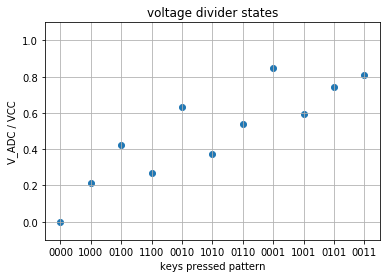

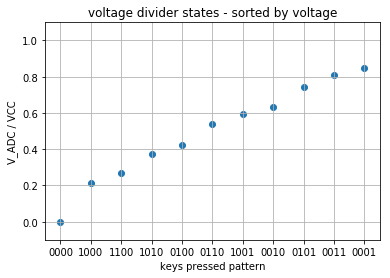

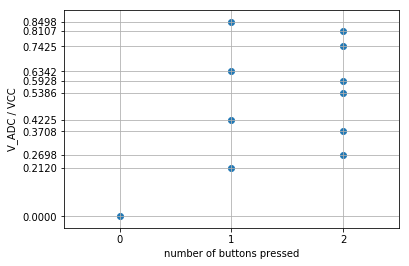

In [6]:
# now plot our results

plt.scatter(combination_number,fractions)
plt.title("voltage divider states")
plt.xlabel("keys pressed pattern")
plt.ylabel("V_ADC / VCC")

plt.xticks(range(11),labels)
plt.ylim(-0.1,1.1)
plt.grid(True)
plt.show()


############

plt.scatter(combination_number,fractions_sorted)
plt.xlabel("keys pressed pattern")
plt.ylabel("V_ADC / VCC")
plt.title("voltage divider states - sorted by voltage")
plt.xticks(range(11),labels_sorted)
plt.ylim(-0.1,1.1)
plt.grid(True)
plt.show()

############

plt.scatter(buttons_pressed,fractions)
plt.xlabel("number of buttons pressed")
plt.ylabel("V_ADC / VCC")
plt.xlim(-.5,2.5)
plt.xticks([0,1,2])
plt.ylim(-0.05,.9)
plt.yticks(fractions_sorted)
plt.grid(True)
plt.show()

In [7]:
# calculate the distances between adjacent output voltages

distances = []
for i in range(1,len(fractions_sorted)):
  distances += [fractions_sorted[i]-fractions_sorted[i-1]]


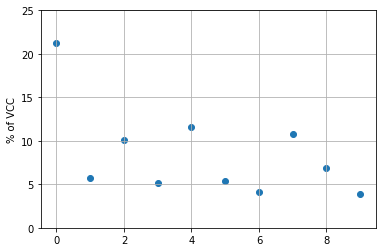

smallest distance
= 0.039% of VCC


In [8]:
plt.scatter(range(0,len(distances)),np.array(distances)*100)
plt.ylim(0,25)
plt.grid(True)
plt.ylabel("% of VCC")
plt.show()

min_distance = np.min(distances)

print("smallest distance")
print("= {:3.3f}% of VCC".format(min_distance))

In [9]:
for i in range(0,len(bit_codes)):
  fraction  = fractions[i]
  bit_code  = bit_codes[i]
  print("ADC: {:04d}, bit code: {:04b}".format(int(fraction*1023),bit_code))

ADC: 0000, bit code: 0000
ADC: 0216, bit code: 0001
ADC: 0432, bit code: 0010
ADC: 0275, bit code: 0011
ADC: 0648, bit code: 0100
ADC: 0379, bit code: 0101
ADC: 0550, bit code: 0110
ADC: 0869, bit code: 1000
ADC: 0606, bit code: 1001
ADC: 0759, bit code: 1010
ADC: 0829, bit code: 1100


In [10]:
# with error margins

for i in range(0,len(bit_codes)):
  fraction  = fractions[i]
  bit_code  = bit_codes[i]
  adc_lo = np.max([int((fraction-min_distance/2)*1023)+1,0])
  adc_hi = np.min([int((fraction+min_distance/2)*1023)-1,1023])
  print("ADC: {:04d}-{:04d}, bit code: {:04b}".format(adc_lo,adc_hi,bit_code))

ADC: 0000-0018, bit code: 0000
ADC: 0197-0235, bit code: 0001
ADC: 0413-0451, bit code: 0010
ADC: 0257-0294, bit code: 0011
ADC: 0629-0667, bit code: 0100
ADC: 0360-0398, bit code: 0101
ADC: 0531-0569, bit code: 0110
ADC: 0850-0888, bit code: 1000
ADC: 0587-0625, bit code: 1001
ADC: 0740-0778, bit code: 1010
ADC: 0810-0848, bit code: 1100


In [11]:
# with error margins, sorted

#create a dictionary
bit_codes_dict = {}
for i in range(0,len(bit_codes)):
  fraction  = fractions[i]
  bit_code  = bit_codes[i]
  bit_codes_dict[fraction] = bit_code
    

for i in range(0,len(fractions_sorted)):
  fraction  = fractions_sorted[i]
  bit_code  = bit_codes_dict[fraction]
  adc_lo = np.max([int((fraction-min_distance/2)*1023)+1,0])
  adc_hi = np.min([int((fraction+min_distance/2)*1023)-1,1023])
  print("ADC: {:04d}-{:04d} -> bit code: 0b{:04b}".format(adc_lo,adc_hi,bit_code))

ADC: 0000-0018 -> bit code: 0b0000
ADC: 0197-0235 -> bit code: 0b0001
ADC: 0257-0294 -> bit code: 0b0011
ADC: 0360-0398 -> bit code: 0b0101
ADC: 0413-0451 -> bit code: 0b0010
ADC: 0531-0569 -> bit code: 0b0110
ADC: 0587-0625 -> bit code: 0b1001
ADC: 0629-0667 -> bit code: 0b0100
ADC: 0740-0778 -> bit code: 0b1010
ADC: 0810-0848 -> bit code: 0b1100
ADC: 0850-0888 -> bit code: 0b1000
